本教程面向非计算机专业的同学，将介绍一些使用deepmd-kit（分子动力学计算）、deepks（量化计算）等软件时可能用到的深度学习知识。在这个教程中你将学到如何训练神经网络来拟合一个简单的函数。神经网络模型的训练无需使用显卡，在个人笔记本电脑上花费几十秒就能完成训练（支持windows/linux/mac os系统）。

运行教程中的代码需要安装pytorch(cpu版本)，matplotlib（用于画图）和jupyter notebook，建议安装Anaconda来运行本教程，安装方法网上可以搜到。安装好相关环境之后，可以使用下面的命令安装pytorch、matplotlib和jupyter notebook

```
# conda安装
conda install pytorch -c pytorch
conda install matplotlib jupyter notebook

# 或者pip安装（与conda安装只能二选一）
pip install pytorch
pip install matplotlib jupyter notebook
```

理论上神经网络可以拟合任意函数，这里将给出一个神经网络拟合`cos`函数的例子,首先用python写一个`cos`函数：

In [78]:
import math
def func(x):
    return math.cos(x)

上面的`func`函数接受一个输入x，输出cos(x)。接下利用`func`函数生成一批数据

In [79]:
# 先定义x的区间为0-4和6-8，然后在这两个区间上随机生成500个数据
intervals = [[0, 4], [6, 8]]
data_num = 500

In [80]:
import random
from copy import deepcopy

# 给定x的区间和数据量，根据func生成相应的数据
def random_data(intervals, data_num):
    total_len = 0
    for interval in intervals:
        total_len += (interval[1] - interval[0])
    data_density = data_num / total_len

    data_pairs = []
    for interval in intervals:
        # 求出该区间上需要产生的数据有多少个
        _data_num = int((interval[1] - interval[0]) * data_density)
        for i in range(_data_num):
            x = random.uniform(interval[0], interval[1])
            y = func(x)
            data_pairs.append((x, y))
    print('data_num:', len(data_pairs))
    return data_pairs

def data_pairs_to_list(data_pairs, shuffle=False):
    x_list = []
    y_list = []
    if shuffle:
        data_pairs = deepcopy(data_pairs)
        random.shuffle(data_pairs)

    for d in data_pairs:
        x_list.append([d[0]])
        y_list.append([d[1]])
    return x_list, y_list    

data_pairs = random_data(intervals, data_num)

data_num: 499


因为有取整操作，只产生了499个数据，但这对后面的操作没有有影响。  
接下来将会用到一个三层的神经网络模型，每层网络都由一个线性层（nn.Linear, 即$y=a*x+b$）和一个激活函数（nn.ReLU, 即activation(x) = max(x, 0))组成，计算方式为：  
$$y = max(a * x + b, 0)$$
其中x为当前层的输入，a和b可以理解为神经元，在模型训练的过程中它们的值会根据我们输入的数据发生改变，完成对数据的学习。激活函数activation(x)的计算方式为max(x, 0)，即当x大于0时，保持不变，当x小于0时输出0。很多个这样的函数堆叠之后就形成了神经网络：  
$y1 = max(a1 * x1 + b1, 0)$  
$y2 = max(a2 * y1 + b2, 0)$  
$y3 = max(a3 * y2 + b3, 0)$  
...  
使用Deepmd和Deepks等软件时，神经网络都已经写好，只需要调节相关参数，准备数据并训练就行。下面给出的这个神经网络有三个参数可以调节：
- `width`: 代表每一层网络神经单元的数量，`width`值必须大于等于2；
- `depth`: 代表有几层神经网络，`depth`值必须大于等于2，且最好小于10；
- `activation`：激活函数种类，只能选择`relu`或`tanh`；

Deepmd-kit中用到的神经网络，以及该网络可以调节的参数跟下面这个神经网络模型几乎完全一样：

In [81]:
import torch
import torch.nn as nn

class FittingNet(nn.Module):
    def __init__(self, width: int, depth: int, activation: str) -> None:
        super().__init__()
        assert width >= 2, 'width should be greater than 2'
        assert activation in {"relu", "tanh"}, "activation should be relu or tanh"
        
        self.width = width
        self.depth = depth
        self.activation = nn.ReLU() if activation == 'relu' else nn.Tanh()
        self.layer1 = nn.Linear(1, width)
        layers = []
        for i in range(depth - 2):
            layers.append(nn.Linear(width, width))
            layers.append(self.activation)
        self.layers = nn.Sequential(*layers)
        self.layer3 = nn.Linear(width, 1)
        
    def forward(self, inputs):
        inputs1 = self.activation(self.layer1(inputs))
        if self.depth > 2:
            inputsn = self.layers(inputs1)
        ret = self.layer3(inputsn)
        return ret

接下还要实现一套训练代码。

In [88]:
batch_size = 10
x_list, y_list = data_pairs_to_list(data_pairs)
x_list = torch.tensor(x_list)
y_list = torch.tensor(y_list)

model = FittingNet(width=10, depth=3, activation='relu')
opt = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 200, 0.8)
model.train()

loss_list = []
start_idx = 0
end_idx = batch_size
numb_steps = 2000
for numb_steps in range(numb_steps):
    while end_idx < len(x_list):
        xs = x_list[start_idx: end_idx, :]
        ys_label = y_list[start_idx: end_idx, :]
        
        ys = model(xs)
        
        loss = ((ys - ys_label)**2).sum() / batch_size
        loss_list.append(loss.item())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        start_idx += batch_size
        end_idx += batch_size
    
    start_idx = 0
    end_idx = batch_size
    scheduler.step()
    if numb_steps > 0 and numb_steps % 200 == 0:
        print('steps: {}, loss: {:.4f}, lr: {:.4f}'.format(numb_steps, sum(loss_list) / len(loss_list), opt.param_groups[0]["lr"]))
    

steps: 200, loss: 0.0849, lr: 0.0080
steps: 400, loss: 0.0505, lr: 0.0064
steps: 600, loss: 0.0342, lr: 0.0051
steps: 800, loss: 0.0258, lr: 0.0041
steps: 1000, loss: 0.0207, lr: 0.0033
steps: 1200, loss: 0.0173, lr: 0.0026
steps: 1400, loss: 0.0149, lr: 0.0021
steps: 1600, loss: 0.0131, lr: 0.0017
steps: 1800, loss: 0.0117, lr: 0.0013


训练过程简单来说就是有n个标注好的训练数据，即n个`x`值和n个`y_label`值，每个`x`, `y_label`都有`y_label = func(x)`. 将n个`x`输入模型，得到模型输出的n个`y_model_output`，然后求`y_label`和`y_model_output`的平方差，就能得到误差loss，即$loss = (y\_label - y\_model\_output)^2$。利用求导公式可以将误差传递回模型中让模型学习，从而让模型的输出越来越接近`y_label`。

训练大概十几秒就能完成。训练过程中应该观察到`loss`值快速下降。  接下来对训练的结果进行可视化，首先来看看训练数据的样子

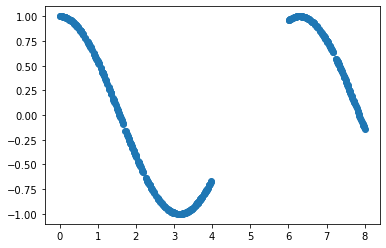

In [89]:
import matplotlib.pyplot as plt

plt.scatter(x_list, y_list)

上图就是训练数据，可以看到我们实现的`func`，也就是`cos`在指定区间[0,4]和[6,8]上的样子。  
接下来再次在[0, 8]范围内随机生成100个x值作为神经网络的输入，看看神经网络的输出跟函数`func`的输出有什么区别。

In [90]:
intervals = [[0, 8]]
data_pairs_new = random_data(intervals, 100)
x_list_new, y_list_new = data_pairs_to_list(data_pairs_new)
x_list_new = torch.tensor(x_list_new)

model.eval()
with torch.no_grad():
    y_model_output = model(x_list_new)


data_num: 100


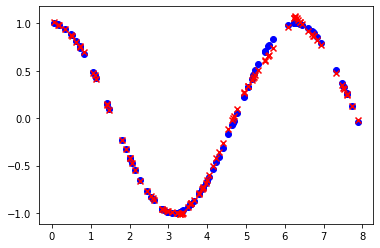

In [91]:
plt.scatter(x_list_new, y_list_new, c='b')
plt.scatter(x_list_new, y_model_output, c='r', marker='x')

上图中蓝色的圆点是我们定义的函数`func`也就是`cos`的值，而红色的x点为模型的输出。可以看到在[0, 4]和[6, 8]区间上，模型的输出结果和`func`的输出非常吻合，而在[4, 6]区间上，尽管红色和蓝色的值非常接近，但偏差明显比[0, 4]和[6, 8]区间大。

可以尝试将`func`中的函数替换成其它任意函数来测试这个模型，比如可以替换成分段函数：

In [66]:
def func(x):
    if x <= 0:
        return -1
    elif 0 < x <= 1:
        return 1
    elif 1 < x <= 2:
        return 3
    elif 2 < x <= 3:
        return 1
    else:
        return 0

替换成上面的分段函数后，选择在区间[0, 2.5]上生成500个训练数据，在区间[0, 4]上画图比较结果，就能得到下面这张图:  
![](figs/1.1-1.png)

在这张图上可以看到，当输入x的范围在[0, 2.5]时，模型跟`func`的结果吻合地很好，但在x超过2.5之后开始出现明显的偏差，而当x>3时，模型的预测结果完全错误。这是因为训练数据是在0 < x < 2.5的范围上生成的，模型从未见过x > 3的数据，而恰好x > 3时`func`的输出发生了巨大的变化，因而模型无法预测。换而言之，**模型无法预测没有学过的东西！**  

教程看到这里，建议尝试将`func`中的函数替换成其它函数，并改变训练的参数，如生成的数据量，模型的`width`和`depth`，训练的步数等来观察训练的情况，目标是使得loss尽可能地低。在训练时有这么几个问题需要注意：
1. `batch_size`代表每次迭代用多少个数据来训练，一般来说这个值越大，训练出来的模型效果越好。但在实践中`batch_size`越大，消耗的内存/显存越多，甚至会导致内存溢出错误（OOM，out of memory）。
2. 一般来说`func`越复杂，需要的神经网络越大（`width`和`depth`都需要加大），需要的数据也越多。自己训练时，`width`设置为2~40，`depth`设置为2~4已经足够用了。
3. 如果loss降不下去，一般首先考虑的是增加训练步数和数据量，调节loss策略，再考虑加大模型；
4. 实践中会将数据集分成训练集+测试集（上面的代码中没有实现），当训练集和测试集上的loss都不再下降时，认为模型训练已经完成；在这个教程中可以认为当训练集的loss不再降低时，训练完成；

理论上神经网络可以逼近任意函数，例如图片分类（输入一张图片，输出图片类别），物体检测（输入一张图片，输出图片物体的类别和位置），自然语言处理（输入一句话，输出针对这句话的回答）等等。只需要将这些输入转换为矩阵，输入模型得到结果，再转换为人类可以理解的输出即可。

在量子化学计算和分子动力学模拟中，很自然就可以想到用神经网络来逼近复杂的势能面，代替第一性原理计算。Deepmd-kit的输入为原子的坐标和元素种类，输出为体系的energy，每个原子的受力force和体系的virial force。其计算速度是第一性原理计算的1000倍以上，更重要的是Deepmd-kit的计算时间跟体系原子数成正比，而传统的第一性原理计算如DFT，其消耗的时间与体系原子数的三次方成正比，因此使用Deepmd-kit可以完成上亿原子的动力学模拟，而这么大的体系使用DFT甚至连算单点能都做不到。  
此外，在上面的实验中可以观察到一个现象：模型在数据集的覆盖范围[0, 4]和[6, 8]区间上表现很好，而在没有覆盖到的区间如[4, 6]上表现就会下降。因此在训练模型时，一个重要的问题是如何产生一个分布足够均匀的数据集，使得模型在待研究的区间上都能保持良好的精度。Deepmd-kit有一个配套的生产数据的工具叫dpgen，可以自动地寻找模型没有覆盖到的区间来生成标注数据。之后的教程中将会介绍这些工具的原理和使用方法：  
deepmd-kit项目: https://github.com/deepmodeling/deepmd-kit  
dpgen项目: https://github.com/deepmodeling/dpgen